In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
SAVE_PLOTS = False

In [2]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics, plot_metrics
from scnn import SNN
from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
time_expector = TimeExpector()

In [3]:
batch_size = 4
nb_epochs = 3

device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

# test_run = True
# if test_run:
#     print('[WARNING] : This is test run.')

In [4]:
%matplotlib inline

# FIXME
my_laptop = False
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
def load_data(trail):
#     if test_run:
#         trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 2 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=60
    )

# original_size = 64
# for __xb, __yb in batchify(
#     'test',
#     DATASET_FOLDER_PATH,
#     CACHE_FOLDER_PATH,
#     condition_limit=['natural'],
#     batch_size=original_size,
#     augmentation=False,
#     max_augmentation=1,
#     frame=60
# ):
#     break

# _hist = {i:0 for i in range(12)}
# for i in __yb:
#     _hist[i] += 1
# max_value = max(_hist.values())

# aug_xb = []
# aug_yb = []
# for i in range(12):
#     idx = np.where(__yb == i)[0][0]
#     to_add = max_value - _hist[i]
#     for _ in range(to_add):
#         aug_yb.append(i)
#         aug_xb.append(__xb[idx, :, :, :])

# # print(__xb.shape)
# # print(__yb.shape)
# __yb = np.concatenate([__yb, np.array(aug_yb)])
# __xb = np.concatenate([__xb, np.array(aug_xb)])
# print(__xb.shape)
# print(__yb.shape)


# def load_data(trail):
#     begin = 0
#     end = begin + batch_size
#     while end <= __yb.shape[0]:
#         yield __xb[begin:end, :, :, :], __yb[begin:end]
#         begin = end
#         end = begin + batch_size

pre-processing dataset: 5034
pre-processing dataset: 441


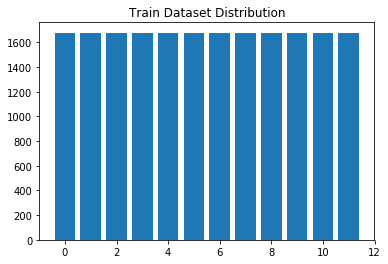

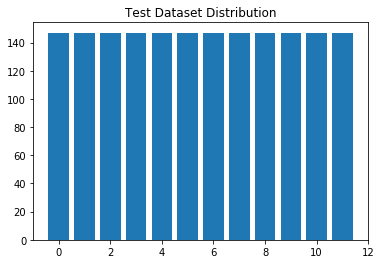

In [5]:
# calculate train dataset size
train_hist = {i:0 for i in range(12)}
test_hist = {i:0 for i in range(12)}
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    for i in y_batch:
        train_hist[i] += 1
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    for i in y_batch:
        test_hist[i] += 1
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

# plt.bar(list(train_hist.keys()), list(train_hist.values()))
# plt.title('Train Dataset Distribution')
# plt.show()
# plt.bar(list(test_hist.keys()), list(test_hist.values()))
# plt.title('Test Dataset Distribution')
# plt.show()

In [6]:
def plot_one_batch(network):
    for X_batch, _ in load_data('train'):
        break

    network.predict(X_batch)

    for i,l in enumerate(network.layers):
        if 'spk_rec_hist' in l.__dict__:
            print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        plot_spikes_in_time(l)

In [10]:
network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector


# tau_mem = 10e-3
# tau_syn = 5e-3
# time_step = 1e-3
# beta = float(np.exp(-time_step / tau_mem))
# weight_scale = 7*(1.0 - beta) # =.6

# network.add_dense(
#     input_shape=(64,64),
#     output_shape=128,              
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

network.add_conv3d(
    input_shape=(64,64),
    
    output_channels=128,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
    lateral_connections=False,
    
    w_init_mean=0.00,
    w_init_std=0.005
)
# network.add_pool2d(kernel_size=(4,4))

# network.add_dense(
#     output_shape=128,
#     w_init_mean=0.0,
#     w_init_std=0.6
# #     lateral_connections=True
# )

network.add_readout(
    output_shape=12,
    time_reduction="max",

    w_init_mean=0.0,
    w_init_std=0.5
)

network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!

Layer 1: average number of spikes=0.1754


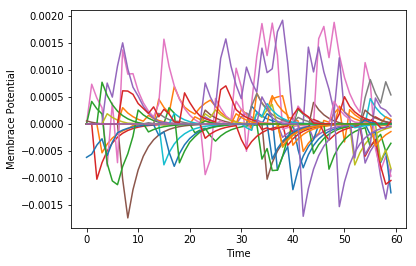

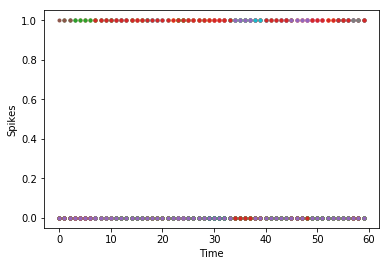

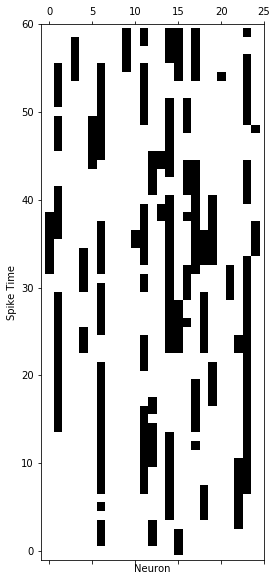

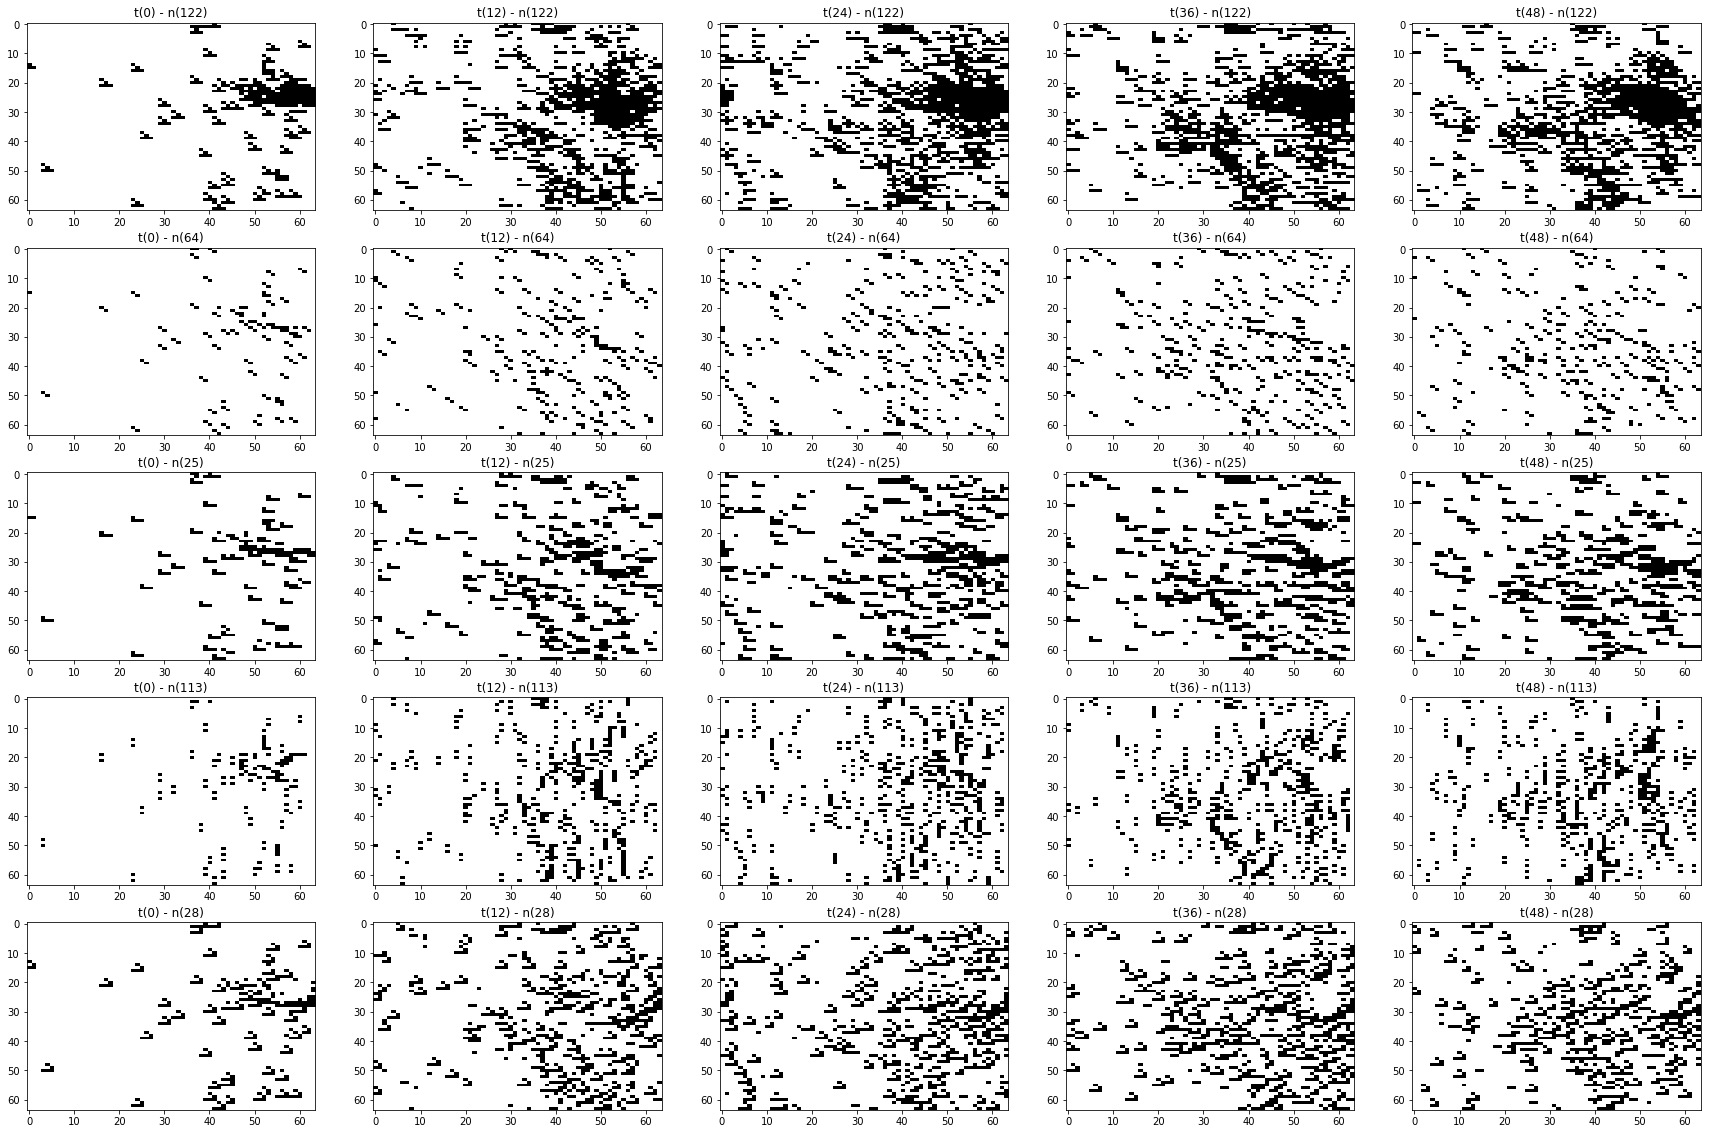

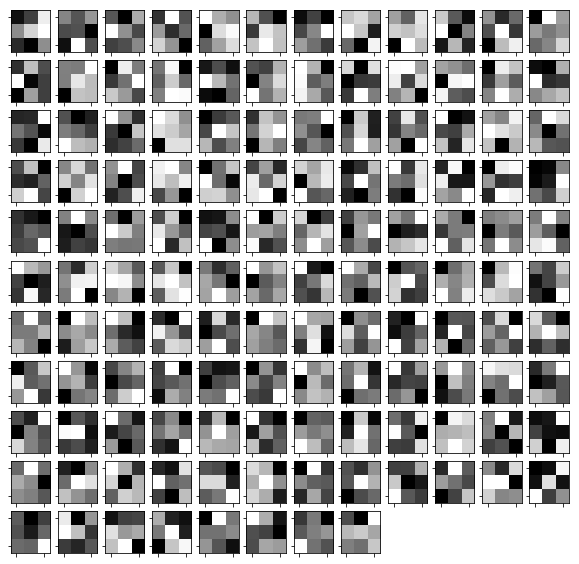

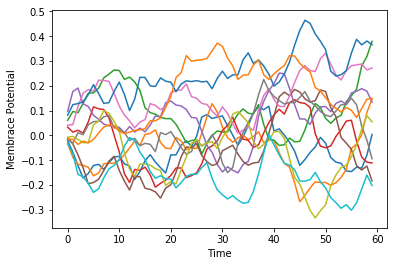

In [ ]:
plot_one_batch(network, save_plots=SAVE_PLOTS)
# print_and_plot_accuracy_metrics(network, load_data('acc_train'), load_data('acc_test'), save_plots=SAVE_PLOTS)

In [ ]:
with open('results.log', 'w') as f:
    lr=0.001
    opt = RAdam(network.get_trainable_parameters(lr))
#     opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=nb_epochs,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f,
        save_checkpoints=False
    )
    plot_metrics(res_metrics, save_plot_path='./metrics_' if SAVE_PLOTS else None)

# network.save('save_network.net')
# network.load('save_network.net')


Epoch: 0 [------------>...............................................] 20%    

In [ ]:
plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./accuracy_' if SAVE_PLOTS else None
)

In [15]:
# network.predict(X_batch)

# # Plotting spike trains or membrane potential
# for i,l in enumerate(network.layers):
#     if not l.HAS_PARAM or 'spk_rec_hist' not in l.__dict__:
#         continue
        
#     if isinstance(l, SpikingDenseLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec, idx=batch_idx)
#     elif isinstance(l, SpikingConv2DLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
#     else:
#         mem_rec = l.mem_rec_hist
#         plot_mem_rec(mem_rec, 0)